In [70]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import json
from private_pgkeys import TEXT_API_KEY
import requests
import time

In [2]:
def run_query(sql):
    '''
    sql: string, raw SQL string command.
    returns: pandas dataframe of the cursor result
    '''
    with sqlite3.connect('yelp.db') as con:
        try:
            df = pd.read_sql(sql, con=con)
            return df
        except Exception as bad:
            print(bad)

# 1. Subsetting the analysis data to remove outliers and only include states with > 10K business listings

In [34]:
sql = '''
SELECT distinct state, AVG(review_count) average_reviews, AVG(stars) average_stars, count(business_id) number_of_businesses 
from business 
GROUP BY state
HAVING count(business_id) > 10000
order by 3 desc
'''

In [38]:
biz_ratings = run_query(sql)
biz_ratings

,state,average_reviews,average_stars,number_of_businesses
0,OR,55.580457,3.863873,25175
1,TX,59.398285,3.846314,24485
2,MA,55.909058,3.618211,36012
3,FL,49.979276,3.554343,21907
4,OH,36.802363,3.533043,11258
5,BC,34.818650,3.512574,17298
6,GA,61.505583,3.507822,18090


In [207]:
plt.rcParams["figure.figsize"] = [16,8]

# 2. Due to Oregon having one of the most populous reviews and the highest average stars, we can focus on the state and find the city which has the most reviews

In [54]:
sql = '''
SELECT distinct(city), state, count(business_id) num_businesses 
from business 
where state = 'OR'
GROUP BY city
ORDER BY 3 DESC
LIMIT 1
'''

run_query(sql)

,city,state,num_businesses
0,Portland,OR,18196


# 3. Within the City of Portland, we find the top 10 businesses with the most reviews

In [86]:
sql = '''
SELECT business_id, name, city, state, review_count, avg(stars) average_stars 
from business 
where state = 'OR' and city = 'Portland'
GROUP BY business_id
ORDER BY 5 DESC
LIMIT 10
'''
run_query(sql)

,business_id,name,city,state,review_count,average_stars
0,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,Portland,OR,9185,3.5
1,OQ2oHkcWA8KNC1Lsvj1SBA,Screen Door,Portland,OR,7219,4.5
2,zioLxtBc9THNS2TOn9xW1w,Pok Pok,Portland,OR,6221,4.0
3,n73rxa6e6-fTIxQzfv4BuA,Mother’s Bistro & Bar,Portland,OR,4466,4.5
4,OPfgKOm_n-ajUo3qjSEgRg,Powell's City of Books,Portland,OR,4295,5.0
5,H_RM2u1WWGU1HkKZrYq2Ow,Blue Star Donuts,Portland,OR,4011,4.0
6,FBQp3R_PQIM9eGnkqzmlOw,Tasty n Alder,Portland,OR,3875,4.5
7,o_L9Ss4boqq6ZEF9xeSH6Q,Salt & Straw,Portland,OR,3672,4.5
8,5oed6H5F8qZxNzELq_1e1w,Pine State Biscuits,Portland,OR,3670,4.5
9,Ys42wLKqrflqmtqkgqOXgA,Luc Lac,Portland,OR,3199,4.0


### For these 10 businesses, let's determine their attributes

In [4]:
sql = '''
SELECT * FROM business_attribute ba
INNER JOIN 
(SELECT business_id, name, review_count
from business 
where state = 'OR' and city = 'Portland'
ORDER BY 3 DESC
LIMIT 10) b on ba.business_id = b.business_id
'''

df = run_query(sql)
df

,business_id,RestaurantsTableService,WiFi,BikeParking,BusinessParking,BusinessAcceptsCreditCards,RestaurantsReservations,WheelchairAccessible,Caters,OutdoorSeating,...,DriveThru,BYOBCorkage,Corkage,RestaurantsCounterService,AgesAllowed,DietaryRestrictions,Open24Hours,business_id,name,review_count
0,4CxF8c3MB7VAdY8zFb2cZQ,None,None,True,"{'valet': False, 'garage': False, 'street': Tr...",True,False,True,False,False,...,None,'yes_free',False,None,None,None,None,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,9185
1,OQ2oHkcWA8KNC1Lsvj1SBA,False,'no',True,"{'garage': False, 'street': True, 'validated':...",True,False,True,True,False,...,None,'no',None,None,None,None,None,OQ2oHkcWA8KNC1Lsvj1SBA,Screen Door,7219
2,zioLxtBc9THNS2TOn9xW1w,None,'no',True,"{'garage': False, 'street': True, 'validated':...",True,True,None,True,True,...,None,'no',None,None,None,None,None,zioLxtBc9THNS2TOn9xW1w,Pok Pok,6221
3,n73rxa6e6-fTIxQzfv4BuA,True,'free',True,"{'garage': False, 'street': True, 'validated':...",True,True,True,False,True,...,True,'yes_corkage',True,None,None,None,None,n73rxa6e6-fTIxQzfv4BuA,Mother’s Bistro & Bar,4466
4,OPfgKOm_n-ajUo3qjSEgRg,None,None,True,"{'garage': True, 'street': True, 'validated': ...",True,None,None,None,None,...,None,None,None,None,None,None,None,OPfgKOm_n-ajUo3qjSEgRg,Powell's City of Books,4295
5,H_RM2u1WWGU1HkKZrYq2Ow,False,'free',True,"{'garage': False, 'street': True, 'validated':...",True,False,True,True,False,...,None,None,None,None,None,None,None,H_RM2u1WWGU1HkKZrYq2Ow,Blue Star Donuts,4011
6,FBQp3R_PQIM9eGnkqzmlOw,False,'no',True,"{'garage': False, 'street': True, 'validated':...",True,False,None,True,False,...,None,None,None,None,None,None,None,FBQp3R_PQIM9eGnkqzmlOw,Tasty n Alder,3875
7,o_L9Ss4boqq6ZEF9xeSH6Q,None,'free',True,"{'garage': False, 'street': True, 'validated':...",True,None,None,False,None,...,False,None,None,None,None,None,None,o_L9Ss4boqq6ZEF9xeSH6Q,Salt & Straw,3672
8,5oed6H5F8qZxNzELq_1e1w,None,'free',True,"{'garage': False, 'street': True, 'validated':...",True,False,True,True,None,...,None,None,None,None,None,None,None,5oed6H5F8qZxNzELq_1e1w,Pine State Biscuits,3670
9,Ys42wLKqrflqmtqkgqOXgA,None,'no',True,"{'garage': False, 'street': True, 'validated':...",True,False,False,True,True,...,None,None,None,None,None,None,None,Ys42wLKqrflqmtqkgqOXgA,Luc Lac,3199


In [196]:
df.T.dropna()

,0,1,2,3,4,5,6,7,8,9
business_id,4CxF8c3MB7VAdY8zFb2cZQ,OQ2oHkcWA8KNC1Lsvj1SBA,zioLxtBc9THNS2TOn9xW1w,n73rxa6e6-fTIxQzfv4BuA,OPfgKOm_n-ajUo3qjSEgRg,H_RM2u1WWGU1HkKZrYq2Ow,FBQp3R_PQIM9eGnkqzmlOw,o_L9Ss4boqq6ZEF9xeSH6Q,5oed6H5F8qZxNzELq_1e1w,Ys42wLKqrflqmtqkgqOXgA
BikeParking,True,True,True,True,True,True,True,True,True,True
BusinessParking,"{'valet': False, 'garage': False, 'street': Tr...","{'garage': False, 'street': True, 'validated':...","{'garage': False, 'street': True, 'validated':...","{'garage': False, 'street': True, 'validated':...","{'garage': True, 'street': True, 'validated': ...","{'garage': False, 'street': True, 'validated':...","{'garage': False, 'street': True, 'validated':...","{'garage': False, 'street': True, 'validated':...","{'garage': False, 'street': True, 'validated':...","{'garage': False, 'street': True, 'validated':..."
BusinessAcceptsCreditCards,True,True,True,True,True,True,True,True,True,True
RestaurantsPriceRange2,1,2,2,2,2,1,2,2,1,2
RestaurantsDelivery,False,False,True,True,None,False,True,True,True,True
GoodForKids,True,True,True,True,True,True,True,True,True,False
business_id,4CxF8c3MB7VAdY8zFb2cZQ,OQ2oHkcWA8KNC1Lsvj1SBA,zioLxtBc9THNS2TOn9xW1w,n73rxa6e6-fTIxQzfv4BuA,OPfgKOm_n-ajUo3qjSEgRg,H_RM2u1WWGU1HkKZrYq2Ow,FBQp3R_PQIM9eGnkqzmlOw,o_L9Ss4boqq6ZEF9xeSH6Q,5oed6H5F8qZxNzELq_1e1w,Ys42wLKqrflqmtqkgqOXgA
name,Voodoo Doughnut - Old Town,Screen Door,Pok Pok,Mother’s Bistro & Bar,Powell's City of Books,Blue Star Donuts,Tasty n Alder,Salt & Straw,Pine State Biscuits,Luc Lac
review_count,9185,7219,6221,4466,4295,4011,3875,3672,3670,3199


### most popular restaurant

In [8]:
df.loc[0][['business_id','name']]

business_id        4CxF8c3MB7VAdY8zFb2cZQ
business_id        4CxF8c3MB7VAdY8zFb2cZQ
name           Voodoo Doughnut - Old Town
Name: 0, dtype: object

In [175]:
import ast

def count_nested_attributes(column_name):
    ambience_counts = {}
    ambience = df[column_name].dropna()
    for i in ambience:
        data = ast.literal_eval(i)
        for key in data.keys():
            if key not in ambience_counts:
                if data[key]:
                    ambience_counts[key] = 1
            else:
                if data[key]:
                    ambience_counts[key] += 1
    return ambience_counts


    

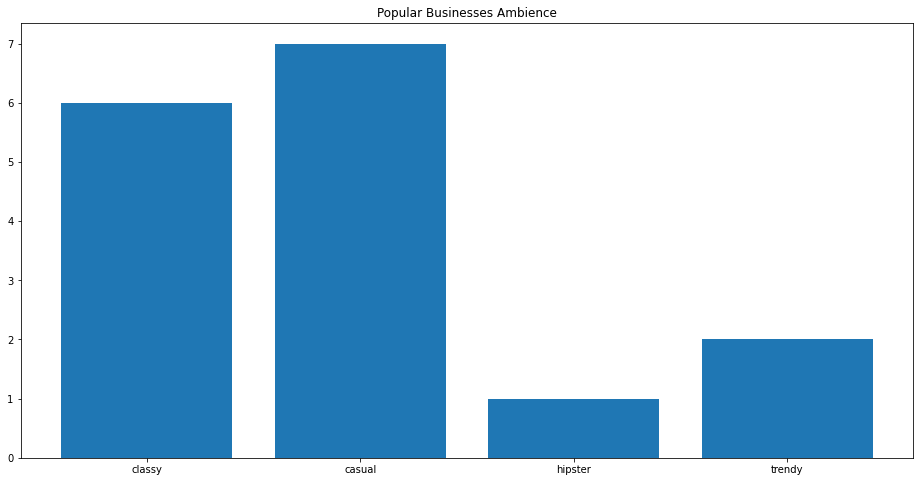

In [193]:
plt.bar(count_nested_attributes('Ambience').keys(), count_nested_attributes('Ambience').values())
plt.title('Popular Businesses Ambience');

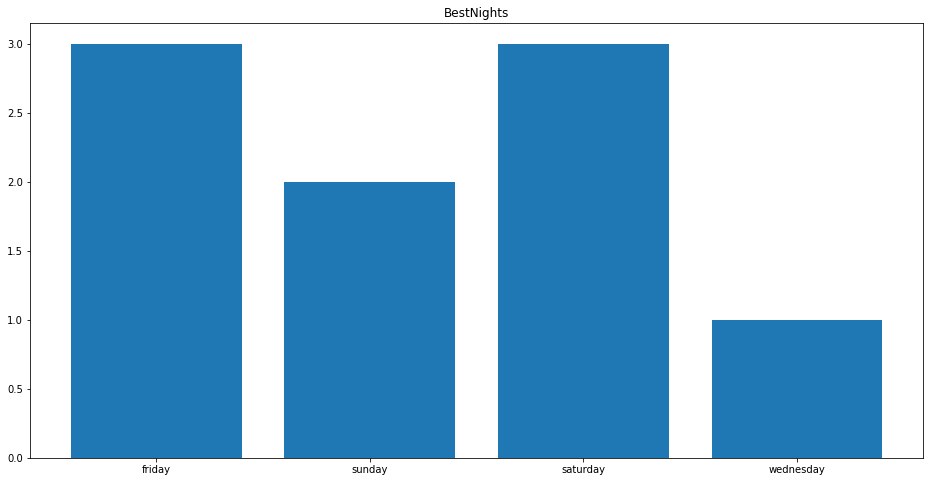

In [190]:
plt.bar(count_nested_attributes('BestNights').keys(), count_nested_attributes('BestNights').values())
plt.title('BestNights');

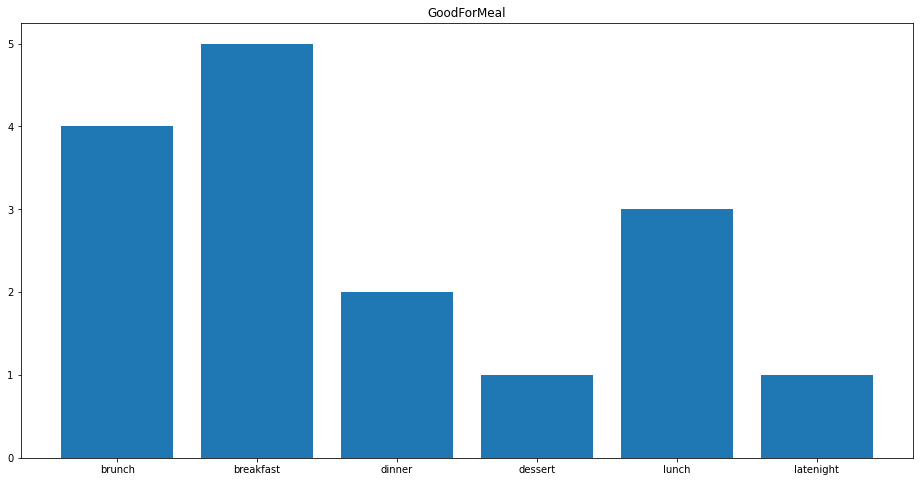

In [194]:
plt.bar(count_nested_attributes('GoodForMeal').keys(), count_nested_attributes('GoodForMeal').values())
plt.title('GoodForMeal');

# 4. For the most popular restaurant in Portland (Voodoo Doughnut - Old Town) Find a repeat reviewer who is the most negative

In [24]:
sql = '''
SELECT r.user_id, u.name username, r.business_id, COUNT(r.review_id) num_reviews, AVG(r.stars) avg_rating
FROM reviews r
INNER JOIN users u on r.user_id = u.user_id
WHERE r.business_id = '4CxF8c3MB7VAdY8zFb2cZQ' 
GROUP BY r.user_id
HAVING COUNT(r.review_id) > 1
ORDER by 4 desc, 3 asc
LIMIT 5
'''
run_query(sql)

,user_id,username,business_id,num_reviews,avg_rating
0,Q2u4PQ5_aMBAQtyX19C1Iw,David,4CxF8c3MB7VAdY8zFb2cZQ,3,3.000000
1,m2XKqIaqB2P5GGm7cqZr2A,Rinky,4CxF8c3MB7VAdY8zFb2cZQ,3,4.666667
2,vsmhQJ5jkw9wQjfpcOfuJA,Duane,4CxF8c3MB7VAdY8zFb2cZQ,3,4.000000
3,1cW_ZPWHNS0IJsxMblwIjw,Judy,4CxF8c3MB7VAdY8zFb2cZQ,2,4.000000
4,31uhwxGQoCvZsy6zitV57Q,Ruby,4CxF8c3MB7VAdY8zFb2cZQ,2,4.000000


In [25]:
# based on the results, we find david who has the most reviews and has the lowest average rating. Let's inspect his reviews in particular to confirm

In [26]:
sql = ''' select *
from reviews r
where r.user_id = 'Q2u4PQ5_aMBAQtyX19C1Iw' 
and r.business_id = '4CxF8c3MB7VAdY8zFb2cZQ'
'''
davids_reviews = run_query(sql)

In [33]:
#expanding notebook display so we can read the full comment
pd.set_option('display.max_colwidth', None)

#seems like david is a frequent visitor and has a bad experience worthy of 1 star
davids_reviews[['stars','text','date']]

,stars,text,date
0,3.0,"Their donuts are interesting to look at but I don't care for the taste of their donuts. The reason I give three stars though is because they have awesome fritters!!!!! It's like an unknown secret LOL! I love the Memphis mafia fritter and the ""ain't that a peach fritter.",2019-02-27 03:29:35
1,5.0,"I went here last night after dinner with a friend and the donuts were delicious. It was a baker's dozen. Our cashier was so nice and accommodating and most importantly the donuts she picked were delicious! They have a great variety of donuts and have really improved, i think my favorites were the cake donut with vanilla frosting and M and M's and my other favorite was a simple vanilla frosted yeast donut. They put so much frosting on top which makes the donuts super yummy! All the donuts tasted fresh and were recently bakedI highly recommend voodoo donuts now! The service was top notch and fast, both pluses!",2020-09-30 13:38:01
2,1.0,"I'm rewriting my review of voodoo. I ordered their memphis mafia which used to be my favorite item, but this time it was very dry and flavorless. My other favorite fritter has been removed from their menu. Those were the only 2 things I've ordered and liked from them.",2019-12-18 20:43:41


# 5. Is David a bringer of bad reviews elsewhere?

In [36]:
sql = ''' 
SELECT avg(r.stars) avg_stars, count(r.review_id) total_review_count
FROM reviews r
WHERE r.user_id = 'Q2u4PQ5_aMBAQtyX19C1Iw' 
and r.business_id != '4CxF8c3MB7VAdY8zFb2cZQ' 
'''
run_query(sql)

,avg_stars,total_review_count
0,4.555556,27


In [37]:
#David seems to give a generous rating outside of Voodoo Doughnuts

# 6. Can we quantify David's sentiments if they are generally positive?, we can score each of his reviews through a sentiment analyzer

In [40]:
#get all of david's reviews
sql = ''' 
SELECT *
FROM reviews r
WHERE r.user_id = 'Q2u4PQ5_aMBAQtyX19C1Iw' 

'''
davids_reviews = run_query(sql)

In [43]:
davids_review_scored = davids_reviews[['review_id','text']].copy()

In [84]:
def add_sentiment_score(text):
    url = "https://google-text-analysis.p.rapidapi.com/AnalyzingSentiment"
    
    #quotes ruin the request payload and the API doesnt handle it well
    text = text.replace('"',"")
    
    print(text)

    payload = "{\r\"message\": \"" + text + "\"\r}"
    headers = {
        'content-type': "application/json",
        'x-rapidapi-key': TEXT_API_KEY,
        'x-rapidapi-host': "google-text-analysis.p.rapidapi.com"
        }

    response = requests.request("POST", url, data=payload, headers=headers)

    resp = response.text
    try:
        score = json.loads(resp)['documentSentiment']['score']
        print(score)
        
        #api throws exceptions when the 1 request per second rule is broken
        time.sleep(5)
        return score
    
    except Exception as e: 
        print(e)
     

In [ ]:
davids_review_scored['score'] = davids_review_scored['text'].map(add_sentiment_score)

In [86]:
davids_review_scored

,review_id,text,score
0,S02GSYVuVx7PqnEi8OLiUg,"I don't care for their donuts at all. I first tried a creme brûlée donut as it was all they had put out. It was afternoon and they had no selection of donuts left. That's unacceptable really. The creme brûlée donut tasted nothing at all like creme brûlée. It was flavorless and bitter. All the seats here were taken so I couldn't sit down with my friend. I don't understand how people like those donuts. But, everyone has a different taste.",-0.6
1,G1O3L_hGb_LsVolG_hAUmg,"Svetlana is a great masseuse. I go for massage therapy for chronic pain. The office is very nice and soothing and she goes out of her way to accommodate you for an appointment. I would highly recommend authentic massage therapy. There are also other types of therapy offered by the practitioners. For those who want different therapies, the website has a whole list.",0.5
2,iZ4AYmnSQescTIjS7uUB3w,Its a very lovely restaurant with an excellent menu. The shrimp scampi with pasta was delicious. They have good appetizers and they have bread for the table. Dessert was also very good. I had a scoop of hazelnut and chocolate gelato. The service was excellent and my friend and I both had a great time at this restaurant. I also don't the prices were are high for their food. I feel their menu is well priced and the quality of food is delicious!,0.6
3,Lhhlqeusne-X2ugOuOU86g,"Dr. NeSmith is so nice! Very compassionate and attentive. I've only had a couple of appointments as I'm new to Oregon, but I'm very pleased with the medical care I receive from her. I'd highly recommend her for any GI problems.",0.9
4,JVTpewcJgjm-KePLwNop2w,"I caution you not to leave a box of 12 at home. You may eat all of them within an hour lol! Seriously, I've always loved Krispy Kreme since I first had them. Their donuts are fresh, fluffy and flavorful. Always a nice treat at the end of a long day. And they're on Grubhub too!!!",0.6
5,REG3Ao2f44r7xs1IX1Oudw,"Such a nice airport! Comfy, spacious, good food etc... it doesn't have a hectic feeling like so many other airports. Love having the MAX, public transit connect right to the airport! :)",0.9
6,AwRQcKpl7e3E1l5XtwRAlA,I really like their food! They have yummy corned beef and cabbage egg rolls with a nice mustard sauce. Their sauce goes so well with egg rolls. They have bangers and mash which is also delicious. They have a large bar and the alcohol bottles are lined up behind the bartenders all the way to the ceiling! It was really cool to see that. There's a ladder too so the bartender can climb up and get your choice of drink. The location is perfect in the yamhill district of SW Portland. The service is quick too and every employee I encountered was very friendly!,0.8
7,OO3zm_Wr-SsLBoyrSWieCQ,I'm really please I picked this allergy clinic. I was moving from out of town and wasn't sure what to expect. The nurse Kendra was very nice and thorough and the allergist PA Jen was very attentive and caring. I also like that I can get an allergy shot on the same day as an appointment. That wasn't the case at my last allergy clinic. Thank you!,0.4
8,sTWgxaKRXD_dnu9ZG_XwwA,"I've been a fan of Fogo de chao for years now. The one in downtown Portland is super delicious. Great variety of food and different selections of meat. They also have excellent desserts too. Their customer service is excellent as well. It's a great place to throw a party as the choices are vast. The restaurant accommodates different people's desires and food preferences. No need to worry if your friend or family member is vegan or keto or gluten free, the table bar has many different types of food. Great place to dine. Make sure you go hungry!",0.8
9,5nbY1JO2l27lZIN8gvIC7A,"Their donuts are interesting to look at but I don't care for the taste of their donuts. The reason I give three stars though is because they have awesome fritters!!!!! It's like an unknown secret LOL! I love the Memphis mafia fritter and the ""ain't that a peach fritter.",

In [93]:
#David's Mean sentiment

davids_review_scored['score'].mean()

0.5566666666666666